In [2]:
import pandas as pd
%pylab inline
%load_ext autoreload
%autoreload 2
#%matplotlib nbagg

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

from UKMovementSensing import hsmm

In [5]:
datadir = "/media/sf_VBox_Shared/London/raw/first5/subsets"
path_to_file5sec = os.path.join(datadir, "0__016566_2015-03-24 14-52-30.bin_day1.csv")

In [6]:
filenames = os.listdir(datadir)
filenames = [fn for fn in filenames if os.path.isfile(os.path.join(datadir,fn))]
datasets = [pd.read_csv(os.path.join(datadir,fn)) for fn in filenames]
print(len(datasets))

11


In [8]:
for i in range(len(datasets)):
    datasets[i] = datasets[i].set_index('timestamp')
    datasets[i].index = pd.to_datetime(datasets[i].index) 
    #datasets[i]['Activity'] = [str(a) for a in datasets[i]['Activity']]
    #datasets[i]['filename'] = filenames[i] #TODO weghalen voor nieuwe data

In [10]:
example_index = 2
day1_5sec = datasets[example_index]

print(min(day1_5sec.index))
print(max(day1_5sec.index))
day1_5sec.head()

2015-03-05 04:00:00
2015-03-06 03:59:55


acceleration        EN     anglex     angley     anglez  \
timestamp                                                                      
2015-03-05 04:00:00      0.003365  0.996340 -65.315964  12.839137 -20.705795   
2015-03-05 04:00:05      0.003278  0.998538 -62.658269  13.348475 -23.393921   
2015-03-05 04:00:10      0.002431  0.998578 -62.733459  13.280806 -23.351338   
2015-03-05 04:00:15      0.001929  0.998130 -62.790675  13.155759 -23.364066   
2015-03-05 04:00:20      0.002238  0.998390 -62.790675  13.155759 -23.364066   

                     roll_med_acc_x  roll_med_acc_y  roll_med_acc_z  \
timestamp                                                             
2015-03-05 04:00:00       -0.904853        0.221299       -0.352103   
2015-03-05 04:00:05       -0.886729        0.230470       -0.396355   
2015-03-05 04:00:10       -0.887516        0.229370       -0.395758   
2015-03-05 04:00:15       -0.887516        0.227132       -0.395758   
2015-03-05 04:00:20       -0.887516        0.227132       -0.395758   

                     dev_roll_med_acc_x  dev_roll_med_acc_y  \
timestamp                                                     
2015-03-05 04:00:00           -0.001102            0.001002   
2015-03-05 04:00:05            0.002263            0.001669   
2015-03-05 04:00:10           -0.000157           -0.000412   
2015-03-05 04:00:15            0.000197            0.000648   
2015-03-05 04:00:20            0.000000            0.000668   

                     dev_roll_med_acc_z  invalid  \
timestamp                                          
2015-03-05 04:00:00            0.003621        0   
2015-03-05 04:00:05           -0.004457        0   
2015-03-05 04:00:10           -0.000040        0   
2015-03-05 04:00:15           -0.000378        0   
2015-03-05 04:00:20           -0.000577        0   

                                                  filename  Slot  act  \
timestamp                                                               
2015-03-05 04:00:00  __016580_2015-03-12 09-09-15.bin_day1     1  1.0   
2015-03-05 04:00:05  __016580_2015-03-12 09-09-15.bin_day1     1  1.0   
2015-03-05 04:00:10  __016580_2015-03-12 09-09-15.bin_day1     1  1.0   
2015-03-05 04:00:15  __016580_2015-03-12 09-09-15.bin_day1     1  1.0   
2015-03-05 04:00:20  __016580_2015-03-12 09-09-15.bin_day1     1  1.0   

                                                        act_label  \
timestamp                                                           
2015-03-05 04:00:00  Sleeping and resting (including sick in bed)   
2015-03-05 04:00:05  Sleeping and resting (including sick in bed)   
2015-03-05 04:00:10  Sleeping and resting (including sick in bed)   
2015-03-05 04:00:15  Sleeping and resting (including sick in bed)   
2015-03-05 04:00:20  Sleeping and resting (including sick in bed)   

                                    start_time  subset switched_pos  
timestamp                                                            
2015-03-05 04:00:00  2015-03-05 04:00:00+00:00       0        False  
2015-03-05 04:00:05  2015-03-05 04:00:00+00:00       0        False  
2015-03-05 04:00:10  2015-03-05 04:00:00+00:00       0        False  
2015-03-05 04:00:15  2015-03-05 04:00:00+00:00       0        False  
2015-03-05 04:00:20  2015-03-05 04:00:00+00:00       0        False

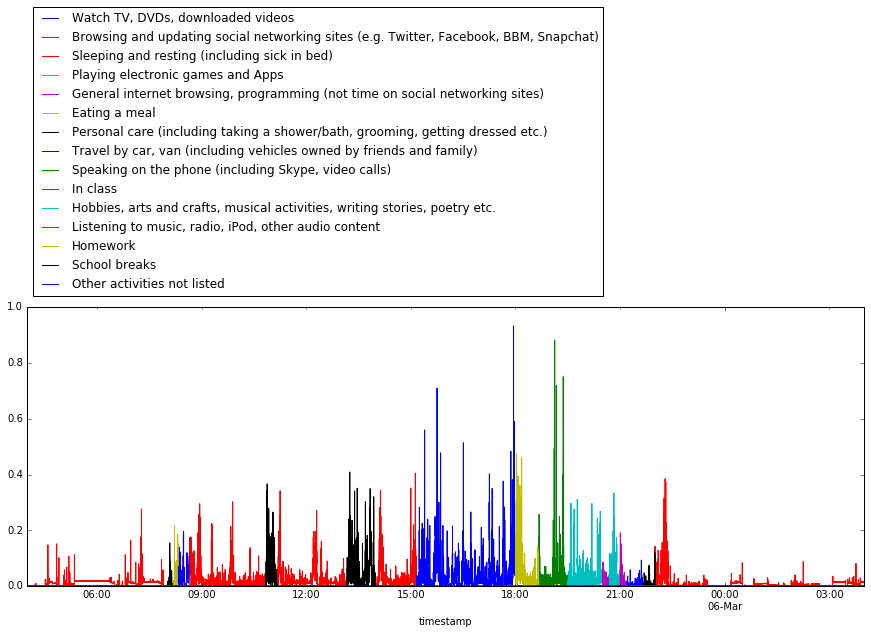

In [11]:
#byAct = day1_5sec.groupby('Activity')
activities = set(day1_5sec['act_label'])
fig, ax = plt.subplots(figsize=(15,5))
for act in activities:
    dfa = day1_5sec.copy()
    dfa[dfa['act_label']!=act] = 0
    dfa['acceleration'].plot(label=act)
legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3);

In [12]:
X_list = [np.column_stack([d.anglex, d.angley, d.anglez, d.acceleration]) for d in datasets] #, day1_5sec.acceleration])
column_names = ['anglex', 'angley', 'anglez', 'acceleration']
print(column_names)

['anglex', 'angley', 'anglez', 'acceleration']


In [13]:
X = X_list[example_index]
print(X.shape)

(17280, 4)


## Create and train the model

In [14]:
Nmax = 4
dim = X.shape[1]

/home/dafne/anaconda2/envs/ucl2/lib/python2.7/site-packages/pybasicbayes/util/stats.py:185: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = np.random.randn(nu,n)


0
Resampled 11 sequences in 27.6 seconds
('Log likelihood: ', -2418087.1631551241)
1
Resampled 11 sequences in 24.3 seconds
('Log likelihood: ', -2241255.7329594423)
2
Resampled 11 sequences in 23.3 seconds
('Log likelihood: ', -2167956.6378760631)
3
Resampled 11 sequences in 23.8 seconds
('Log likelihood: ', -2122874.4306618096)
4
Resampled 11 sequences in 22.4 seconds
('Log likelihood: ', -2095513.0412304597)
5
Resampled 11 sequences in 21.8 seconds
('Log likelihood: ', -2075483.1769899551)
6
Resampled 11 sequences in 22.0 seconds
('Log likelihood: ', -2058397.5513524592)
7
Resampled 11 sequences in 22.0 seconds
('Log likelihood: ', -2042361.3016073252)
8
Resampled 11 sequences in 22.0 seconds
('Log likelihood: ', -2030059.6592235852)
9
Resampled 11 sequences in 22.1 seconds
('Log likelihood: ', -2021165.0541970858)
10
Resampled 11 sequences in 21.4 seconds
('Log likelihood: ', -2013580.9373639682)
11
Resampled 11 sequences in 21.8 seconds
('Log likelihood: ', -2006311.3402186753)
12

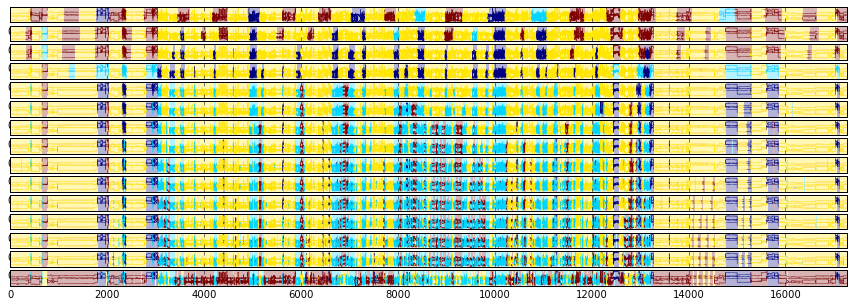

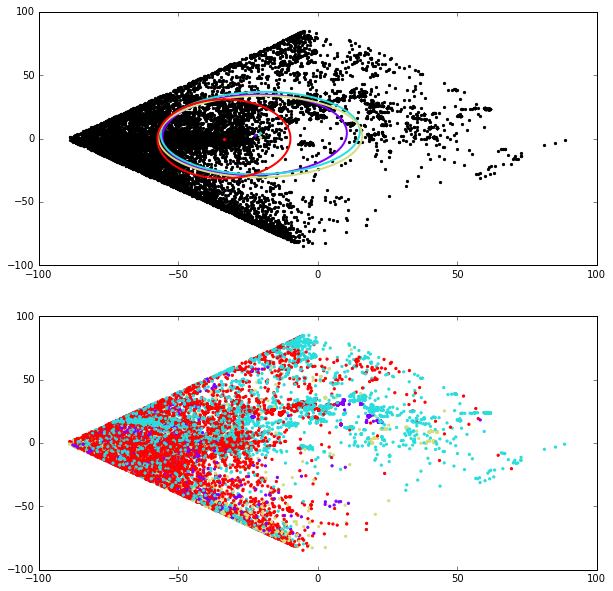

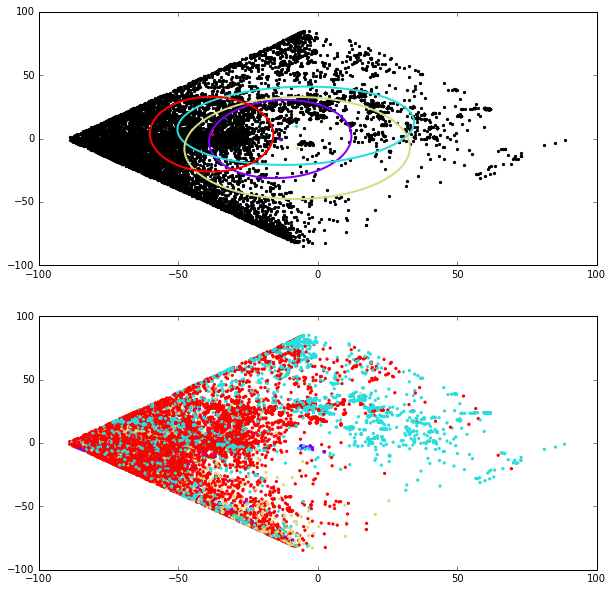

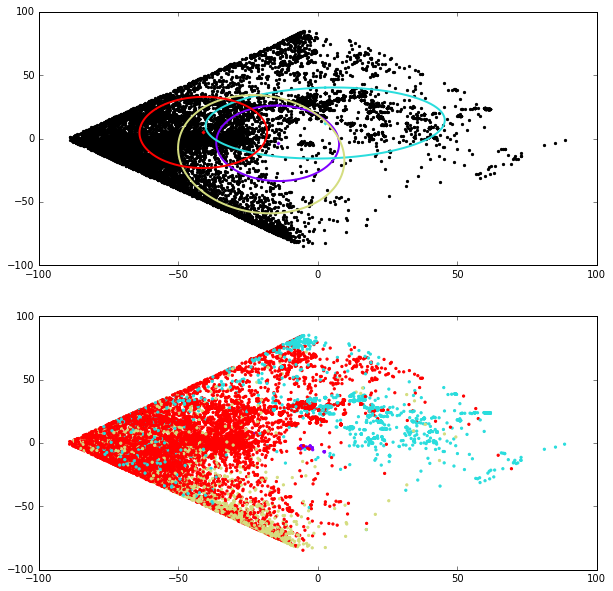

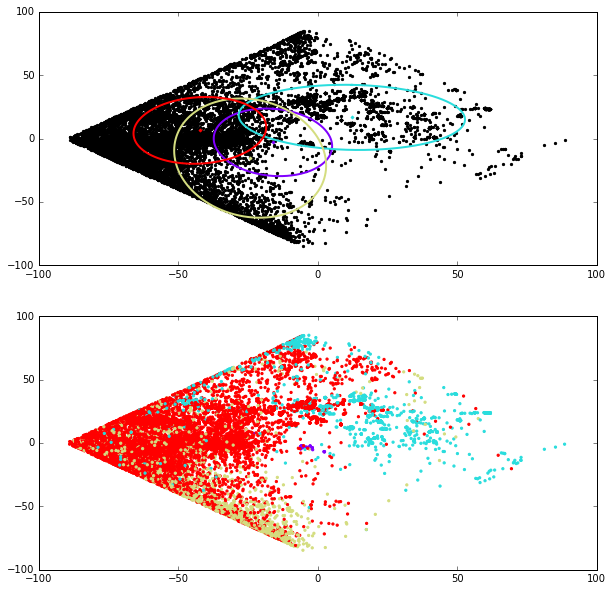

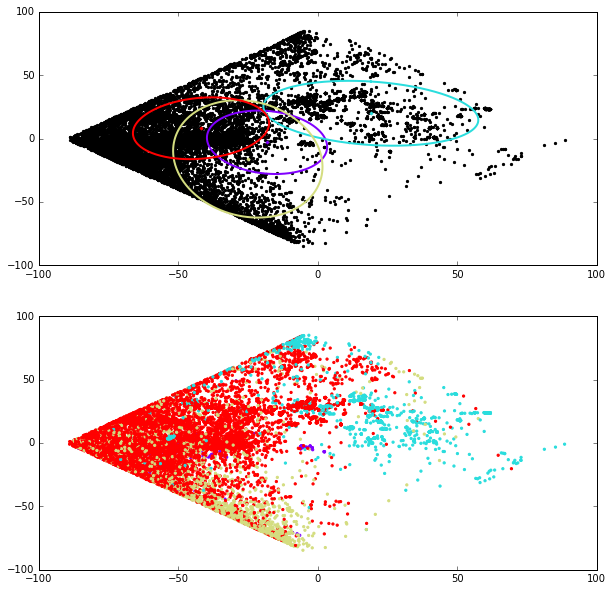

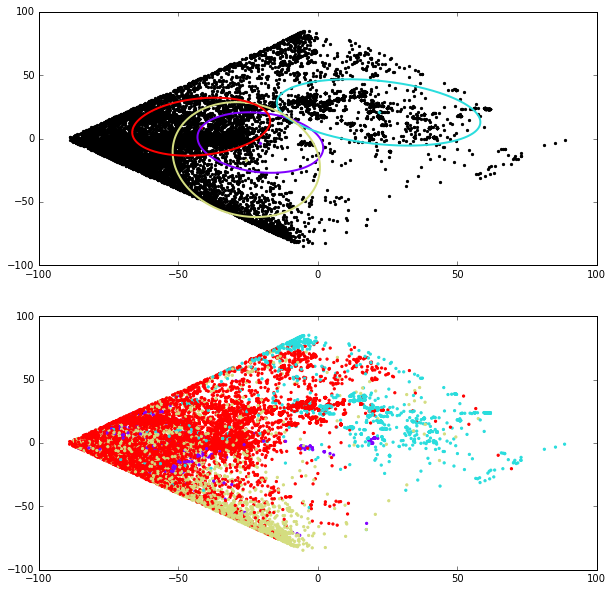

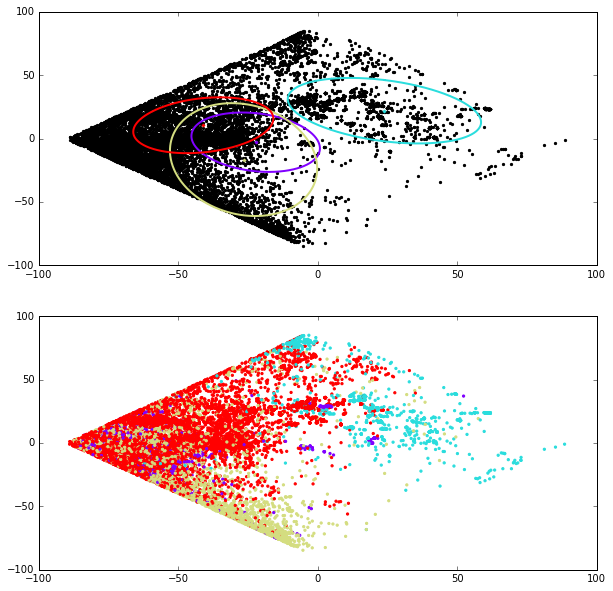

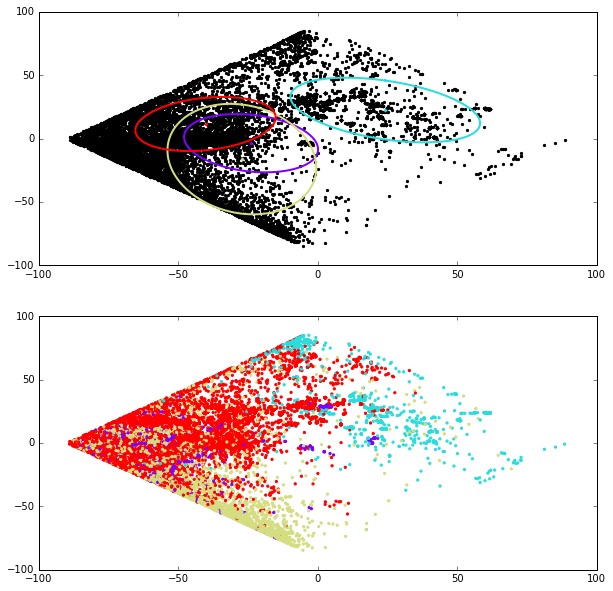

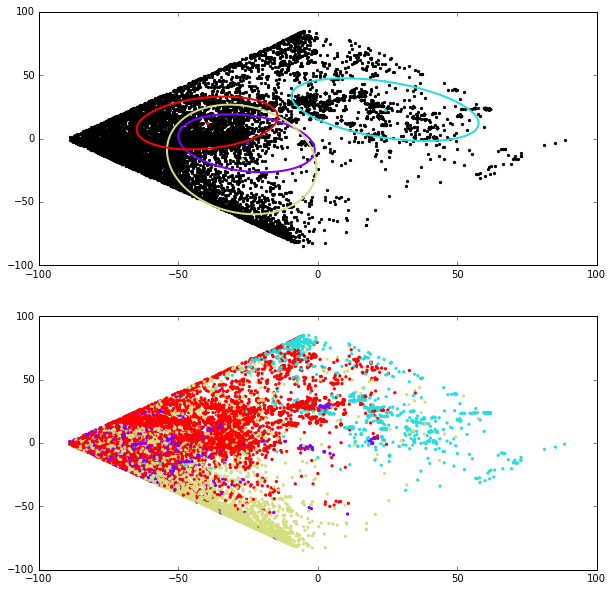

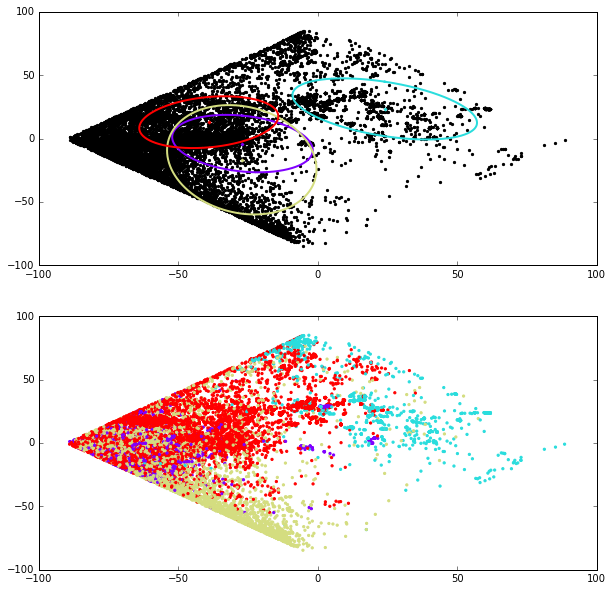

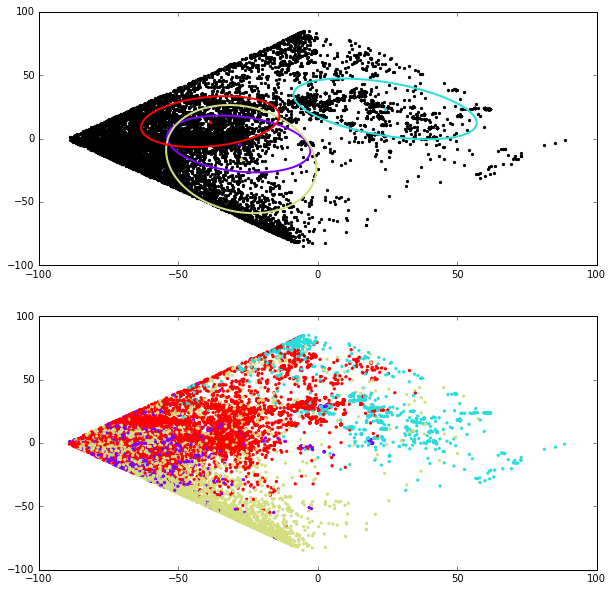

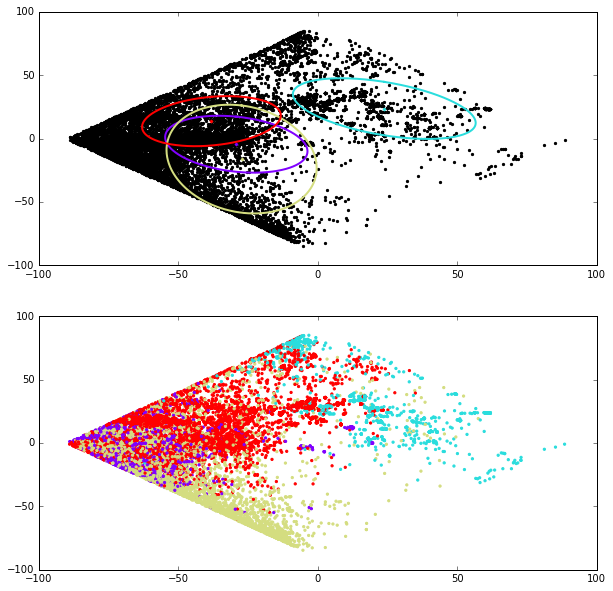

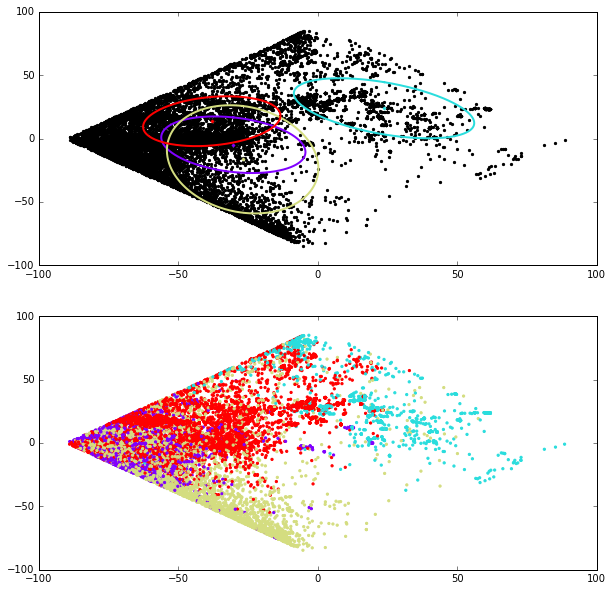

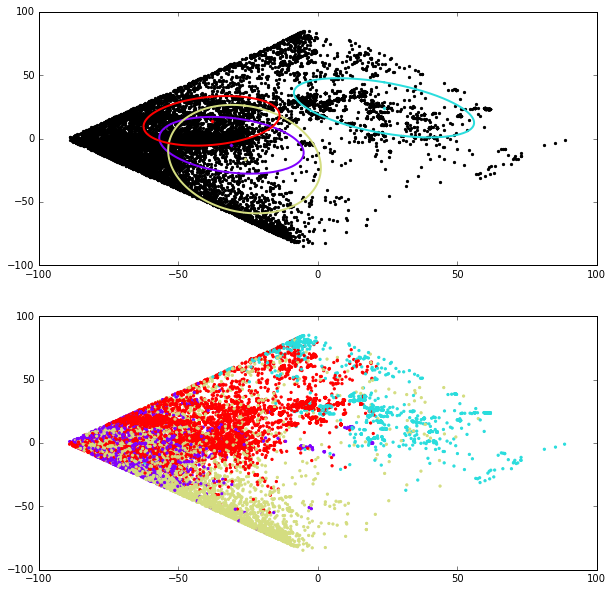

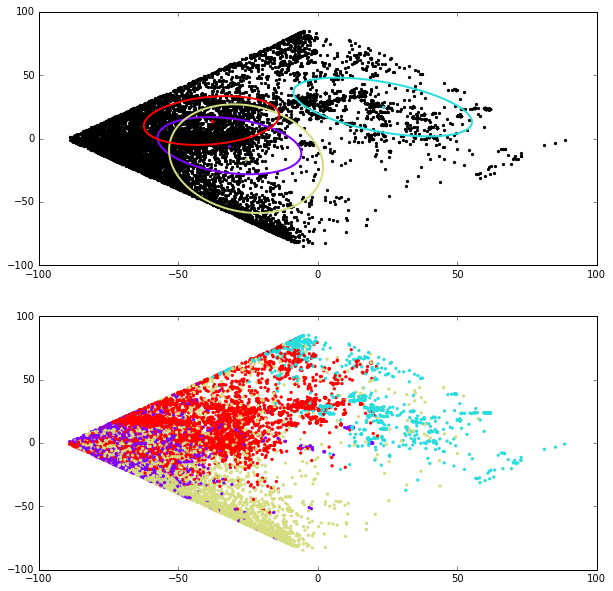

In [15]:
model, model_dist = hsmm.train_hsmm(X_list, Nmax=Nmax, nr_resamples=15, trunc=600, visualize=True, example_index=example_index)

In [16]:
d_old = model_dist[0]
for j, d in enumerate(model_dist):
    #print d[0].mu
    diff = np.array([np.sqrt(np.sum(np.square(d[i].mu - d_old[i].mu))) for i in range(len(d))])
    print(j, np.mean(diff))
    d_old = d

(0, 0.0)
(1, 19.315686459494202)
(2, 10.940586103003602)
(3, 7.021293254117559)
(4, 4.0804128808738094)
(5, 2.3580530715327703)
(6, 2.1095596956235356)
(7, 1.777972077633311)
(8, 1.3901669512029382)
(9, 1.3115467276343216)
(10, 1.0062148019835759)
(11, 0.87658677732813861)
(12, 0.77142959332885608)
(13, 0.63190185988438163)
(14, 0.75954548968079638)


In [52]:
import pickle
#TODO: the model object also contains the data so this is not very efficient
modelpath = os.path.join(datadir, 'models')
if not os.path.exists(modelpath):
        os.makedirs(modelpath)
with open(os.path.join(modelpath, 'model_{}states.pkl'.format(Nmax)), 'wb') as f:
    pickle.dump(model, file=f)

In [ ]:
import pickle
with open(os.path.join(datadir, 'models/model_{}states.pkl'.format(Nmax)), 'r') as f:
    model = pickle.load(file=f)

In [18]:
data = day1_5sec
hidden_states = model.stateseqs[example_index]

In [22]:
#Save the data with the states
outputpath = os.path.join(datadir,'datawithstates/')
if not os.path.exists(outputpath):
        os.makedirs(outputpath)
for i, dat in enumerate(datasets):
    dat['state'] = model.stateseqs[i]
    fn = str(str(dat['subset'][0]) + dat['filename'][0])+'.csv'
    dat.to_csv(os.path.join(outputpath, fn))

In [23]:
colormap, cmap = hsmm.get_color_map(Nmax)

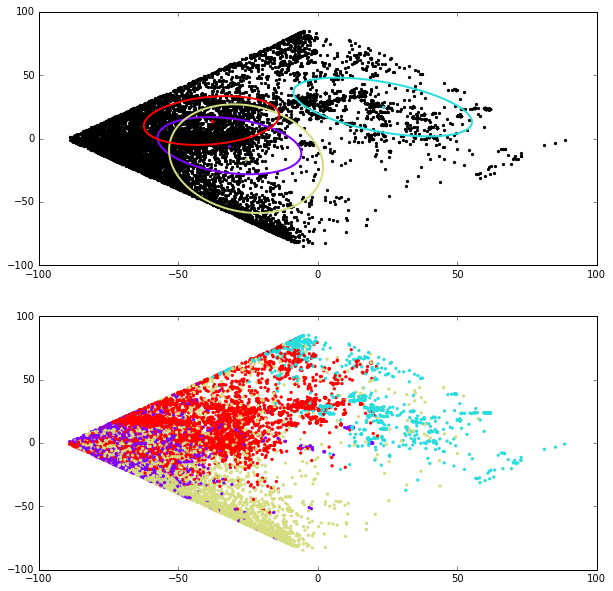

In [25]:
hsmm.plot_observations(X, 0, 1, model, hidden_states, Nmax)

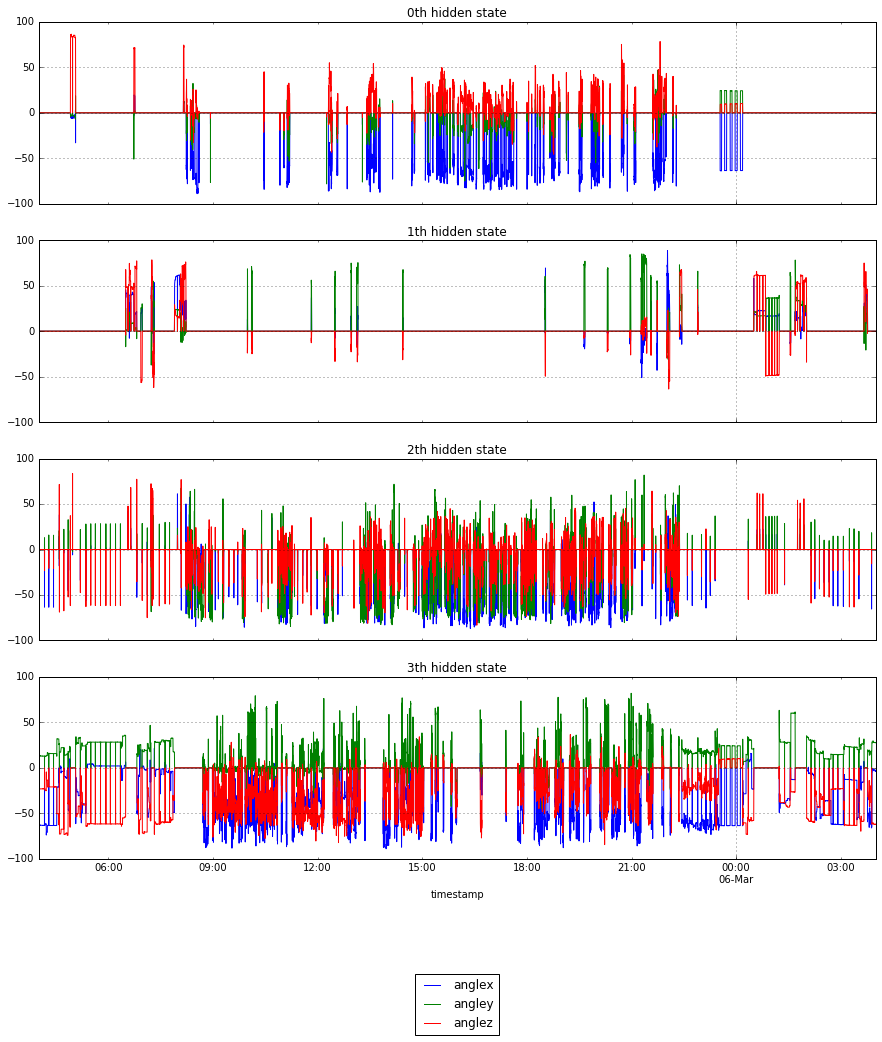

In [26]:
hsmm.plot_perstate(data[['anglex', 'angley', 'anglez']], hidden_states)

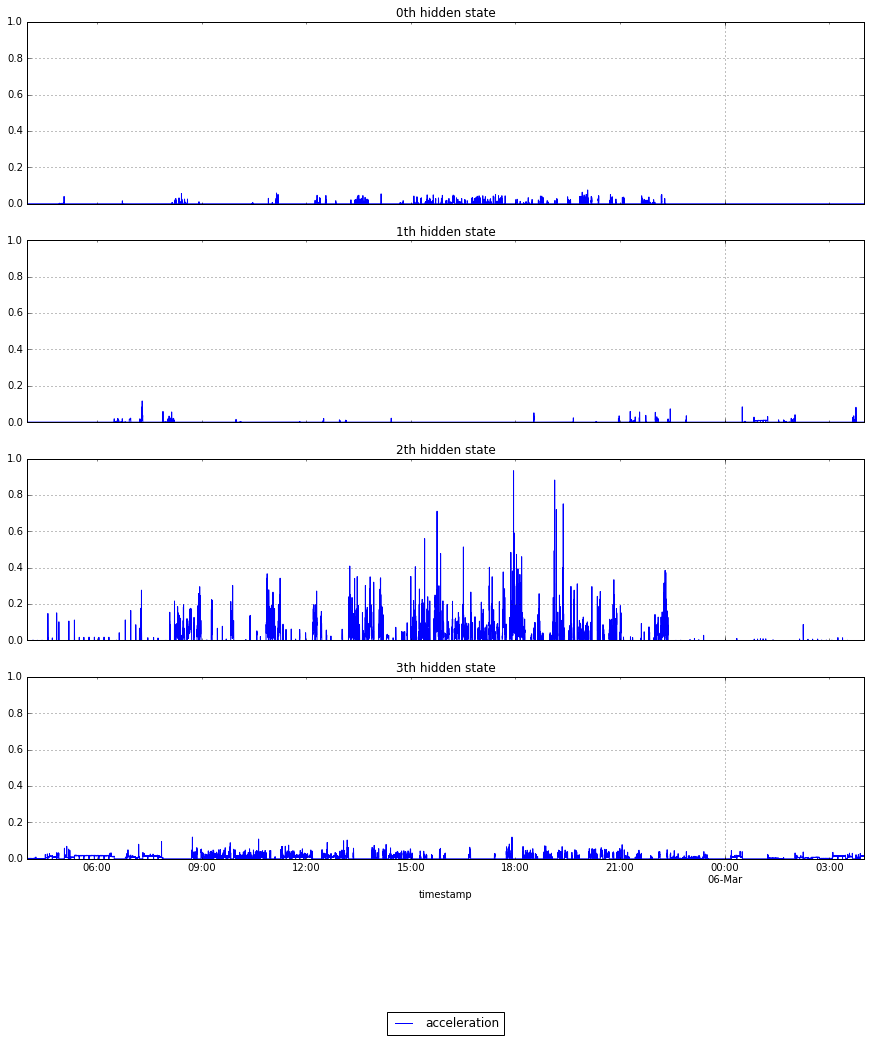

In [27]:
hsmm.plot_perstate(data[['acceleration']], hidden_states)

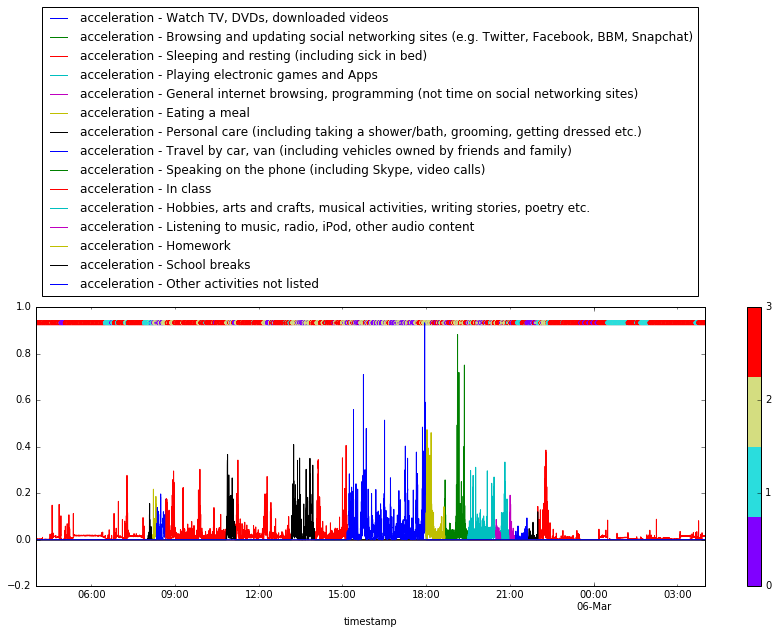

In [29]:
hsmm.plot_states_and_var(data, hidden_states, columns=['acceleration'], by='act_label')

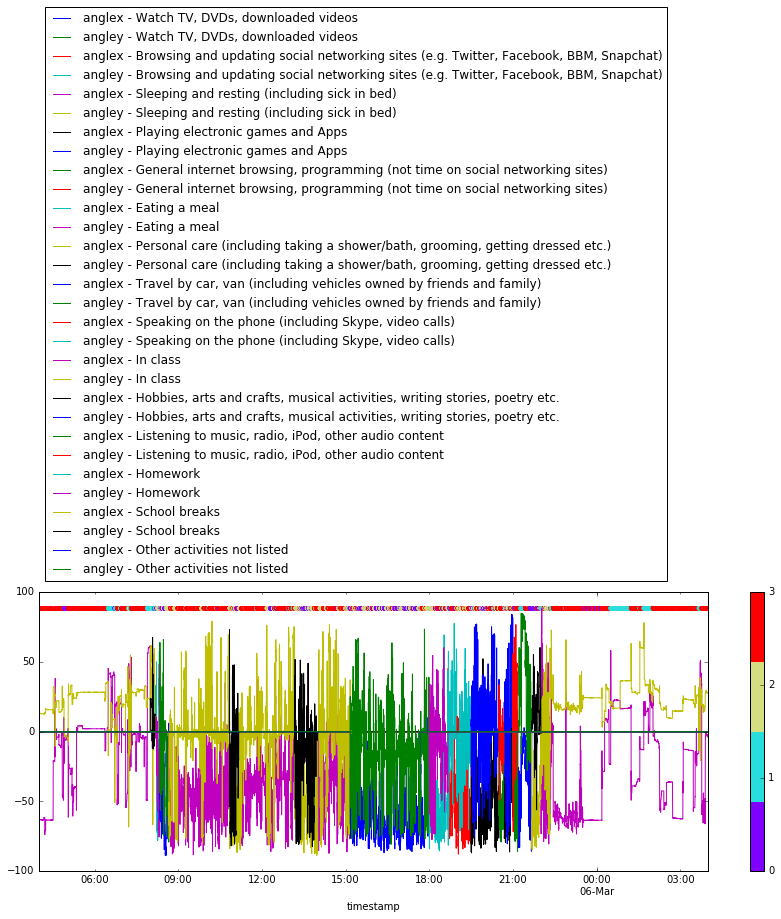

In [31]:
hsmm.plot_states_and_var(data, hidden_states, columns=['anglex', 'angley'], by='act_label')

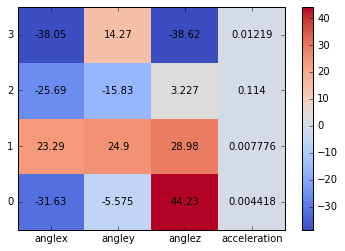

In [32]:
#Plot the means
plotdata = np.array([d.mu for d in model.obs_distns])

hsmm.plot_heatmap(plotdata, horizontal_labels=column_names)

In [33]:
pd.DataFrame(plotdata.transpose(), index=column_names)

0          1          2          3
anglex       -31.627820  23.293084 -25.686264 -38.053614
angley        -5.575133  24.901840 -15.830803  14.271269
anglez        44.228859  28.975155   3.226598 -38.617328
acceleration   0.004418   0.007776   0.114025   0.012194

In [34]:
#Plot the mean of the acceleration
#plotdata2 = plotdata[:,3][:,np.newaxis]
#hsmm.plot_heatmap(plotdata2, column_names)

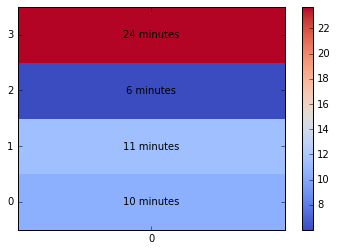

In [35]:
# Plot expected duration
plotdata = np.array([d.lmbda/3. for d in model.dur_distns])[:,np.newaxis]
#grouplabels = ["{:.3} minutes".format(x/3.) for x in plotdata[:,0]]
hsmm.plot_heatmap(plotdata, form='{:.0f} minutes')

Plot the covariance matrix for each state

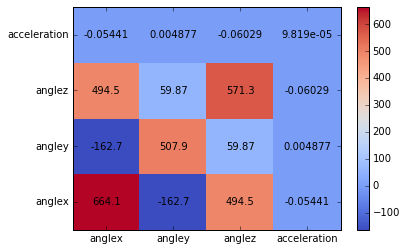

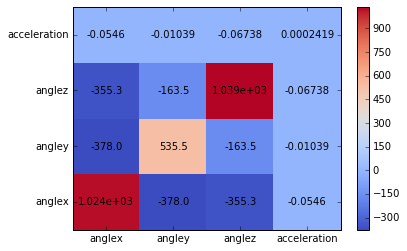

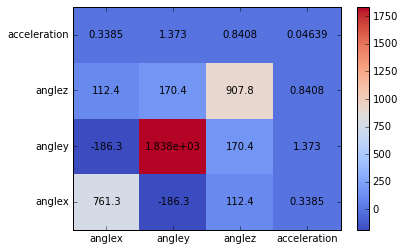

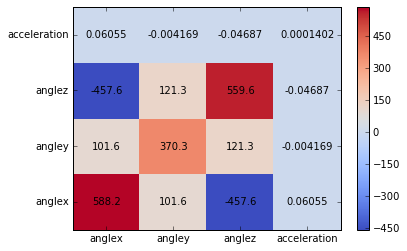

In [36]:
#fig, axs = plt.subplots(nrows=model.num_states, ncols=1,  figsize = (10, 15))
for i in range(model.num_states):
    plotdata = model.obs_distns[i].sigma
    #plt.sca(axs[i])
    hsmm.plot_heatmap(plotdata, horizontal_labels=column_names, vertical_labels=column_names)
#colorbar()
show()

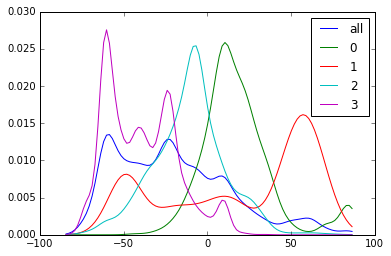

In [37]:
from scipy.stats.kde import gaussian_kde

variable = "anglez"#"acceleration"

fig, ax = subplots()
#day1_5sec.hist(variable, bins=100)
vals = data[variable]
kde = gaussian_kde(vals)
d = np.linspace(min(vals), max(vals), 100)
p = plot(d, kde(d), label="all")

for i in range(model.num_states):
    mask = hidden_states == i
    if(sum(mask)>0 and np.std(vals[mask])>0):
        kde = gaussian_kde(vals[mask])
        plot(d, kde(d), label=str(i))
#ax.set_xlim(0,0.1)
legend()
show()

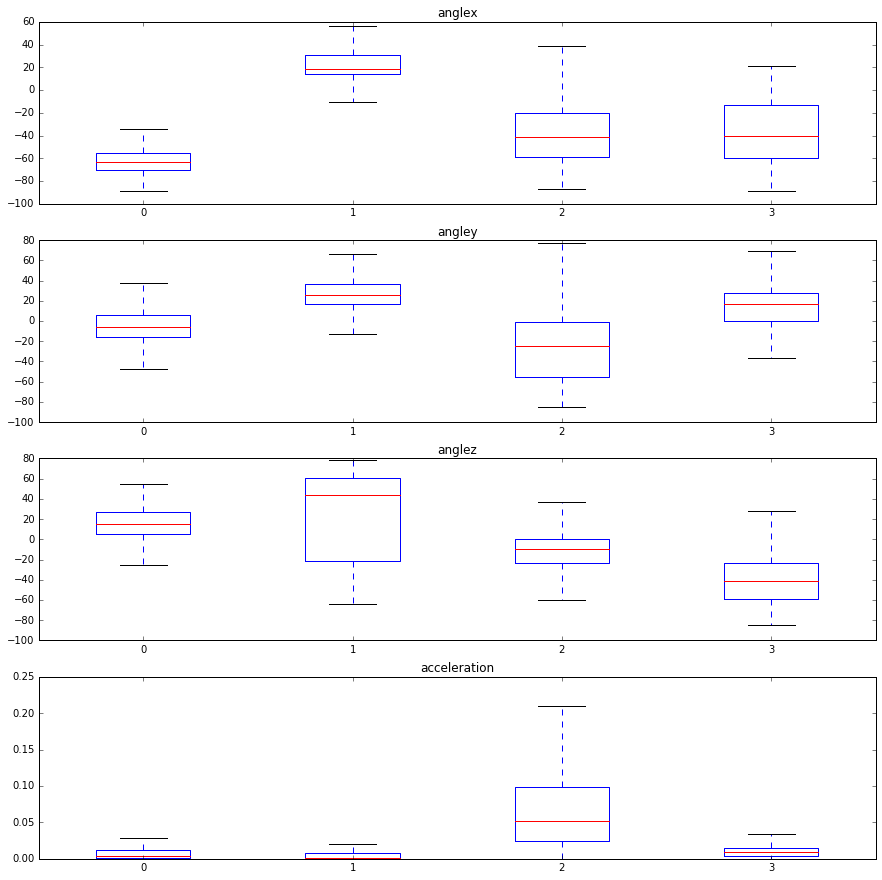

In [38]:
hsmm.plot_boxplots(data[column_names], hidden_states)

In [39]:
def getDurations(hidden_states, nr_states):
    durations = {i: [] for i in range(nr_states)}
    prev = hidden_states[0]
    d = 0
    for x in hidden_states:
        if x == prev:
            d += 1
        else:
            durations[prev].append(d)
            prev = x
            d = 0
    return durations

In [40]:
durations = getDurations(hidden_states, Nmax)
for i, d in durations.iteritems():
    if len(d)>0:
        datdur = np.mean(d)
        distdur = model.dur_distns[i].lmbda
        print('{}\t{:.1f}\t{:.1f}'.format(i, datdur, distdur))
    else:
        print(i)

0	18.6	31.4
1	36.3	34.0
2	15.3	18.1
3	66.5	71.2


In [41]:
all_hidden_states = np.array([s for m in model.stateseqs for s in m])
all_activities = np.array([s for d in datasets for s in list(np.array(d['act_label']))])
print(all_hidden_states.shape)
print(all_activities.shape)

(172620,)
(172620,)


In [42]:
ctab = pd.crosstab(all_activities, all_hidden_states, margins=True).sort_values('All', ascending=False)

In [43]:
ctab

col_0                                                   0      1      2  \
row_0                                                                     
All                                                 47944  33725  43033   
Sleeping and resting (including sick in bed)        28630  19435   5155   
In class                                             5610   4752   7832   
Reading (not for school)                             4514   1397   7311   
Playing electronic games and Apps                     805    440    966   
Speaking, socialising face-to-face                    543   1277   2879   
Watch TV, DVDs, downloaded videos                     419   1100   1452   
Personal care (including taking a shower/bath, ...   1064    767   1920   
Eating a meal                                         680   1169   1587   
School breaks                                        1033    418   1993   
Homework                                              836    853   1283   
Travel by car, van (including vehicles owned by...    162     49   1513   
Did nothing, just relaxing, bored, waiting            322    317    618   
Shopping (including window shopping, hanging ou...    483    256   1102   
Other activities not listed                           779      0    841   
Travel by physically active means (walk, bike e...    270    117   1281   
Hobbies, arts and crafts, musical activities, w...    437    253    708   
Eating a snack or having a drink                      225     96    492   
Individual ball games and training (e.g. tennis...     45     26   1009   
General internet browsing, programming (not tim...    209    271    503   
nan                                                   176    309    143   
Jogging, running, walking, hiking                      15    207    596   
Religious activities (including going to places...    257    112    292   
Cooking, cleaning, and shopping for the household      26     12    614   
Browsing and updating social networking sites (...    163     77    153   
Speaking on the phone (including Skype, video c...     76     10    255   
Listening to music, radio, iPod, other audio co...     73      3    149   
Cycling                                                16      2    342   
Volunteering                                           76      0     44   

col_0                                                   3     All  
row_0                                                              
All                                                 47918  172620  
Sleeping and resting (including sick in bed)        24360   77580  
In class                                             6286   24480  
Reading (not for school)                             1538   14760  
Playing electronic games and Apps                    4149    6360  
Speaking, socialising face-to-face                   1421    6120  
Watch TV, DVDs, downloaded videos                    2429    5400  
Personal care (including taking a shower/bath, ...   1529    5280  
Eating a meal                                        1124    4560  
School breaks                                         516    3960  
Homework                                              628    3600  
Travel by car, van (including vehicles owned by...    556    2280  
Did nothing, just relaxing, bored, waiting            903    2160  
Shopping (including window shopping, hanging ou...    319    2160  
Other activities not listed                           180    1800  
Travel by physically active means (walk, bike e...    132    1800  
Hobbies, arts and crafts, musical activities, w...    282    1680  
Eating a snack or having a drink                      507    1320  
Individual ball games and training (e.g. tennis...      0    1080  
General internet browsing, programming (not tim...     97    1080  
nan                                                   212     840  
Jogging, running, walking, hiking                      22     840  
Religious activities (including going to p

In [44]:
ind = list(ctab.index)
pd.crosstab(all_activities, all_hidden_states, normalize='index', margins=True).loc[ind]

col_0                                                      0         1  \
row_0                                                                    
All                                                 0.277743  0.195371   
Sleeping and resting (including sick in bed)        0.369038  0.250516   
In class                                            0.229167  0.194118   
Reading (not for school)                            0.305827  0.094648   
Playing electronic games and Apps                   0.126572  0.069182   
Speaking, socialising face-to-face                  0.088725  0.208660   
Watch TV, DVDs, downloaded videos                   0.077593  0.203704   
Personal care (including taking a shower/bath, ...  0.201515  0.145265   
Eating a meal                                       0.149123  0.256360   
School breaks                                       0.260859  0.105556   
Homework                                            0.232222  0.236944   
Travel by car, van (including vehicles owned by...  0.071053  0.021491   
Did nothing, just relaxing, bored, waiting          0.149074  0.146759   
Shopping (including window shopping, hanging ou...  0.223611  0.118519   
Other activities not listed                         0.432778  0.000000   
Travel by physically active means (walk, bike e...  0.150000  0.065000   
Hobbies, arts and crafts, musical activities, w...  0.260119  0.150595   
Eating a snack or having a drink                    0.170455  0.072727   
Individual ball games and training (e.g. tennis...  0.041667  0.024074   
General internet browsing, programming (not tim...  0.193519  0.250926   
nan                                                 0.209524  0.367857   
Jogging, running, walking, hiking                   0.017857  0.246429   
Religious activities (including going to places...  0.356944  0.155556   
Cooking, cleaning, and shopping for the household   0.036111  0.016667   
Browsing and updating social networking sites (...  0.271667  0.128333   
Speaking on the phone (including Skype, video c...  0.158333  0.020833   
Listening to music, radio, iPod, other audio co...  0.152083  0.006250   
Cycling                                             0.044444  0.005556   
Volunteering                                        0.633333  0.000000   

col_0                                                      2         3  
row_0                                                                   
All                                                 0.249293  0.277592  
Sleeping and resting (including sick in bed)        0.066448  0.313998  
In class                                            0.319935  0.256781  
Reading (not for school)                            0.495325  0.104201  
Playing electronic games and Apps                   0.151887  0.652358  
Speaking, socialising face-to-face                  0.470425  0.232190  
Watch TV, DVDs, downloaded videos                   0.268889  0.449815  
Personal care (including taking a shower/bath, ...  0.363636  0.289583  
Eating a meal                                       0.348026  0.246491  
School breaks                                       0.503283  0.130303  
Homework                                            0.356389  0.174444  
Travel by car, van (including vehicles owned by...  0.663596  0.243860  
Did nothing, just relaxing, bored, waiting          0.286111  0.418056  
Shopping (including window shopping, hanging ou...  0.510185  0.147685  
Other activities not listed                         0.467222  0.100000  
Travel by physically active means (walk, bike e...  0.711667  0.073333  
Hobbies, arts and crafts, musical activities, w...  0.421429  0.167857  
Eating a snack or having a drink                    0.372727  0.384091  
Individual ball games and training (e.g. tennis...  0.934259  0.000000  
General internet browsing, programming (not tim...  0.465741  0.089815  
nan                                                 0.170238  0.252381  
Jogging, running, walking,

In [45]:
mask_notnan = np.array(all_activities) != 'nan'
print(mask_notnan.shape)
print()

(172620,)
()


In [48]:
mask_notnan = np.array(all_activities) != 'nan'
all_activities_sub = np.array(all_activities)[mask_notnan]
all_hidden_states_sub = np.array(all_hidden_states)[mask_notnan]
ind = list(ctab.index[2:])
ctab = pd.crosstab(all_activities_sub, all_hidden_states_sub, normalize='columns', margins=True).loc[ind]

In [51]:
print(ctab)

FloatingPointError: invalid value encountered in greater

In [ ]:
all_acceleration = np.array([s for d in datasets for s in list(np.array(d['acceleration']))])
df_as = pd.DataFrame({'acc': all_acceleration, 'state': all_hidden_states})
df_as.groupby('state').mean().transpose()

In [ ]:
df_as.groupby('state').std().transpose()

In [ ]:
print([d.lmbda*5.0/60 for d in model.dur_distns])

In [ ]:
len(model.dur_distns)

In [ ]:
model.trans_distn.full_trans_matrix.tofile(os.path.join(datadir, 'models/model_{}states_transmatrix'.format(Nmax)))